In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd
import sympy as sym
from odeintw import odeintw
import multitype_new as mt
import importlib
importlib.reload(mt)
from scipy.integrate import odeint

cmp = plt.cm.get_cmap('Set2')
sns.set_palette("Set2")

/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_35836/4092617615.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmp = plt.cm.get_cmap('Set2')


In [5]:
# Parameters to change 
save = False
immigration = False


ntypes = 8
nexposed = int(ntypes/2)

# Disease Parameters
Reff_vec = np.array((2., 2.5, 3., 3.5, 4.))
gamma = 1/7 # Recovery Rate
sigma = 1/3 # Progression rate from exposed to infectious

# Relative susceptibility for different types 

sus_ur = 1-0.4 # Susceptibility of unvaccinated, previously infected against new strain
sus_vu = 1-0.6 # Susceptibility of vaccinated, not previously infected against new strain
sus_vr = np.min((sus_ur, sus_vu)) # Susceptibility of vaccinated, previously infected against new strain


Tmax = 1000 
num = Tmax 
time = np.linspace(0, Tmax, num=num)
dtime = time[1]-time[0]


# Proportion of population in each type
p_vac = 0.7
p_no_vac = 1- p_vac 

p_rec = 0.2 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus

# Reduced susceptibility for each type based on infection/vaccine immunity
const_vec = np.array((1., sus_ur, sus_vu, sus_vr))
prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))
scale = const_vec*prop_vec



# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

im = 0
im_vec = np.zeros(ntypes)
y0 = np.zeros(ntypes)
y0[0] = 1
ics = np.zeros(ntypes)

trans_rec = 1 - 0.4 # Reduction in transmission if recovered from previous strain
trans_vac = 1 - 0.7 # Reduction in transmission if vaccinated (but not previously infected)
trans_all = np.min((trans_rec, trans_vac)) # Reduction in transmission if vaccinated and recovered from previous strain

trans_vec = np.array((1., trans_rec, trans_vac, trans_all))
trans_vec = np.ones(nexposed)



In [40]:
y0

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [54]:

# plt.plot(q_mat[0, :])
rho = (odeint(mt.set_odes, ics, time, args = (P, omega_vec)).T )
q = np.ones_like(time)
for i in range(ntypes):
    q *= rho[i, :] ** y0[i]


[ 0.01094828 -0.33333333 -0.48713876 -0.33333333 -0.33333333 -0.14285714
 -0.14285714 -0.14285714]


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


[ 0.03624173 -0.33333333 -0.5124322  -0.33333333 -0.33333333 -0.14285714
 -0.14285714 -0.14285714]


100%|██████████| 1000/1000 [00:34<00:00, 28.71it/s]


[ 0.05939235 -0.33333333 -0.53558283 -0.33333333 -0.33333333 -0.14285714
 -0.14285714 -0.14285714]


100%|██████████| 1000/1000 [00:26<00:00, 38.07it/s]


[ 0.08086708 -0.33333333 -0.55705756 -0.33333333 -0.14285714 -0.33333333
 -0.14285714 -0.14285714]


100%|██████████| 1000/1000 [00:23<00:00, 41.69it/s]


[ 0.10098448 -0.33333333 -0.57717496 -0.33333333 -0.33333333 -0.14285714
 -0.14285714 -0.14285714]


100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


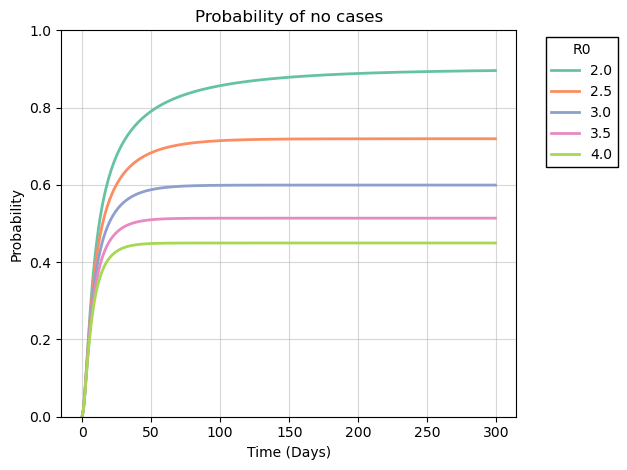

In [57]:
q_mat = np.zeros((len(Reff_vec), len(time)))

R_vec = np.zeros_like(Reff_vec)


# Initialise Mean
mean = np.zeros((len(Reff_vec), len(time)))
plot_log = 1

mean_arr = np.zeros((len(Reff_vec), ntypes, len(time)))
    
# Initialise Variance
variance = np.zeros((len(Reff_vec), len(time)))
lamb_vec = np.zeros(len(Reff_vec)) # Vector of growth rates for each R0
var_mat = np.zeros((len(Reff_vec), len(time), ntypes, ntypes))

# Initialise Tstar
Tstar_idxs = np.zeros(len(Reff_vec))
Tstars = np.zeros(len(Reff_vec))
epsilon = 1e-3
# Plotting Parameters
showplot = 100
showplot_rho = 300

R_effective_vec = np.zeros(len(Reff_vec))
for r, Reff in enumerate(Reff_vec):
    beta_baseline = Reff*gamma

    RV = Reff
    
    omega_vec = sigma * np.ones(ntypes) 

    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_baseline)*trans_vec[nex] + gamma
        

    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_baseline) + gamma)
        

        sum_gen_funcs = np.sum((beta_baseline*prop_vec/omega)*const_vec*u[:nexposed])
         
        for nex in range(0, nexposed):

            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs  + (gamma/omega)
        
        return pvec            
            
            
    eta = im_vec.astype(float)
    


    
    # offspring = P
    # outbreak = mt.MTBP(offspring, time)
    # outbreak.set_immigration(eta)
    # outbreak.set_baseline_rates(beta_baseline, gamma)
    # outbreak.set_proportions(prop_vec)
    # outbreak.set_susceptibility(const_vec)
    # outbreak.set_rel_transmission_rates(None)


# Mean of the Process
# Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)       

    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_baseline)*trans_vec[nex] + gamma
        Omat[nex, nex+nexposed] = omega_vec[nex]
        Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_baseline *trans_vec[nex]
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_baseline * prop_vec)*trans_vec[nex]

    Omat -= np.diag(omega_vec)


    

    Mvec = odeint(mt.set_mean_odes, y0, time, args = (Omat,)).T
    mean_arr[r, :, :] = Mvec

    mean[r, :] = np.sum(Mvec, axis=0)


    # outbreak.set_rel_transmission_rates(trans_vec)

    
    rho = (odeint(mt.set_odes, ics, time, args = (P, omega_vec)).T )# Solve ODEs for probabilities of extinction/zero
    q = np.ones_like(time)
    for i in range(ntypes):
        q *= rho[i, :] ** y0[i]
    
    # Variance and Coefficient of Variation
    param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, "g":gamma, "beta":beta_baseline}

    variance[r, :] = mt.variance(time, y0, omega_vec, Omat, [prop_vec, const_vec, beta_baseline, gamma])
 
    # var_mat[r, :, :, :] = outbreak.get_var_mat()
    RV = np.round(Reff_vec[r], 2)
    sig_over_mean = (np.sqrt(variance[r, :])/(mean[r, :]))
    
    q_mat [r, :] = q

    
    
    plt.figure(1)

    plt.plot(time[:showplot_rho], q_mat[r, :showplot_rho], lw=2, label = str(np.round(RV, 2)))


plt.figure(1)
plt.grid(alpha = 0.5)
plt.title("Probability of no cases" )
plt.xlabel("Time (Days)")
plt.ylabel("Probability")
plt.ylim([0, 1])
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()

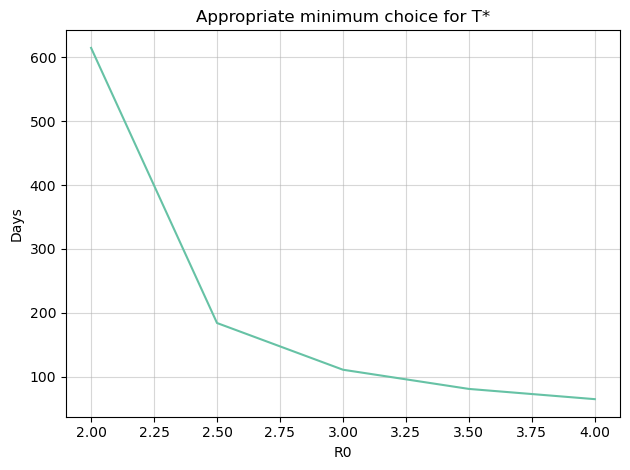

In [83]:


plt.figure()
plt.grid(alpha = 0.5)
plt.plot(Reff_vec, Tstars)
plt.title("Appropriate minimum choice for T*")
plt.xlabel("R0")
plt.ylabel("Days")

Istars_min = np.zeros(len(Reff_vec))
for r in range(0, len(Reff_vec)):
    sig_over_mean = (np.sqrt(variance[r, :])/(mean[r, :]))
    Tstar = mt.Tstar(time, q_mat[r, :], sig_over_mean, thresh1 = epsilon, thresh2 = epsilon)

    Tstar_idxs[r] = int(Tstar[0])
    # Tstar_idxs = Tstar_idxs.astype(int)
    Tstars[r] = Tstar[1]
    
    Istars_min[r] = mean[r, Tstar_idxs[r]]

plt.tight_layout()

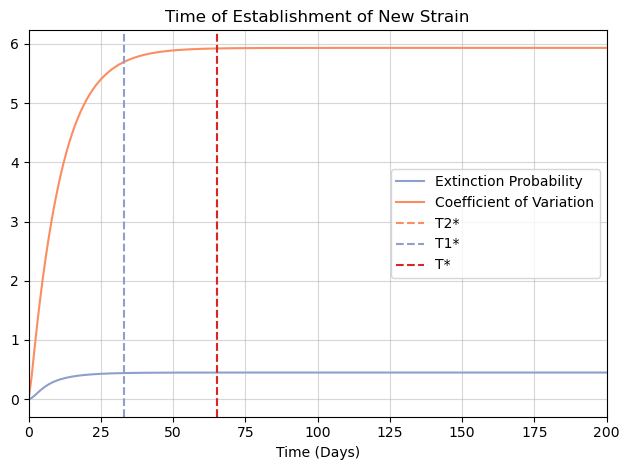

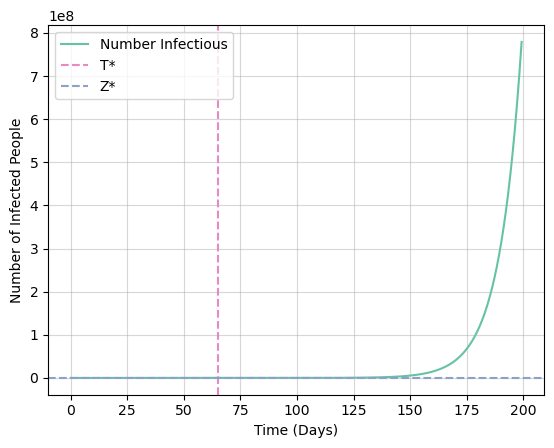

In [84]:
plt_idx = -1
dtime = time[1] - time[0]
var_coeff = np.sqrt(variance[plt_idx, :])/(mean[plt_idx, :])
var_coeff_grad =  np.abs(np.gradient(var_coeff.flatten(), dtime))
tstar_var_coeff = np.where(var_coeff_grad<=1e-3)[0][0]

q_grad = np.gradient(q_mat[plt_idx, :200].flatten(), dtime)
tstar_q = np.where(q_grad<=1e-3)[0][0]


cmap = sns.color_palette("Set2")

plt.figure()

if im == 0:
    plt.plot(time[:400], q_mat[plt_idx, :400], label = "Extinction Probability", color = cmap[2])

else:
    plt.plot(time[:400], rho_mat[plt_idx, :400], label = "Extinction Probability", color = cmap[2])
plt.plot(time[:400], np.sqrt(variance[plt_idx, :400])/(mean[plt_idx, :400]), label = "Coefficient of Variation", color = cmap[1])
plt.grid(alpha = 0.5)
plt.axvline(time[tstar_var_coeff], color = cmap[1], linestyle = '--', label = "T2*")
plt.axvline(time[tstar_q], color = cmap[2], linestyle = '--', label = "T1*")
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))] , color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Time of Establishment of New Strain")
plt.xlabel("Time (Days)")
plt.xlim([0, 200])
#plt.legend(loc=2, bbox_to_anchor=(1.01, 1), framealpha=1., edgecolor='black', fancybox=False)
plt.legend()
plt.tight_layout()
# plt.savefig("Tstar_choice_R=" + str(int(4)) + ".png")



plt.figure(13)

plt.plot(time[:200], mean[plt_idx, :200], label='Number Infectious')
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))] , color = cmap[3], linestyle = '--', label = "T*")
plt.axhline(mean[plt_idx, np.max((tstar_q, tstar_var_coeff))] , color = cmap[2], linestyle = '--', label = "Z*")

plt.grid(alpha = 0.5)
plt.xlabel("Time (Days)")
plt.ylabel("Number of Infected People")

plt.legend()

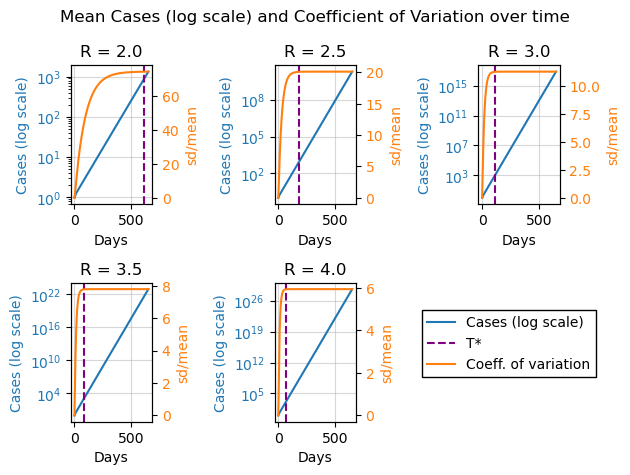

In [85]:
save = 0

showplot = 300
Istars_min = np.zeros(len(Reff_vec))
for r in range(0, len(Reff_vec)):
    Istars_min[r] = mean[r, Tstar_idxs[r]]
    
#     tst_idx[r] = np.min(np.where(mean[r, :]>=threshold))
showplot = 650

fig, axs = plt.subplots(2, 3)
for r in range(0, len(Reff_vec)):
    sig_vec = np.sqrt(variance)
    RV = np.round(Reff_vec[r], 2)
    if r<=2:
        b = 0
    else:
        b=1    
    color = 'tab:blue'
    if r ==0:
        
        axs[b, r%3].plot(time[:showplot], mean[r, :showplot] , color = color, label = "Cases (log scale)")
    else:
        axs[b, r%3].plot(time[:showplot], mean[r, :showplot] , color = color)
        axs[b, r%3].axvline(time[Tstar_idxs[r]], color = 'purple', linestyle = '--')
    axs[b, r%3].tick_params(axis='y', labelcolor=color)
    axs[b, r%3].grid(alpha = 0.5)
    axs[b, r%3].set_ylabel("Cases (log scale)", color = color)
    axs[b, r%3].set_ylabel("Cases (log scale)", color = color)
    axs[b, r%3].set_xlabel("Days")
    axs[b, r%3].set_yscale("log")
    axs[b, r%3].set_title("R = " + str(RV))
    axs[-1, -1].set_visible(False)
    color= 'tab:orange'
    ax1 = axs[b, r%3].twinx()
    if r ==0:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "Coeff. of variation")
        axs[b, r%3].axvline(time[Tstar_idxs[r]], color = 'purple', linestyle = '--', label = str("T*"))

    else:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("sd/mean", color = color)
    
    
    
bottom_right_ax = axs[-1][-1] 
bottom_right_ax.clear()  
bottom_right_ax.set_axis_off()
plt.suptitle("Mean Cases (log scale) and Coefficient of Variation over time")
fig.legend(loc='lower right', bbox_to_anchor=(0.95, 0.2),framealpha=1., edgecolor='black', fancybox=False)
fig.tight_layout()
# if save:
#     plt.savefig("sig_over_mean_plot_im=" + str(im) + ".png")

In [112]:
num_sims = 10000
G_df = pd.read_csv('Gillespie_times_epsilon=0.001.csv').to_numpy()

G_test = np.zeros((len(Reff_vec), num_sims))#
#G_test[0, :] = G_df[0, 1:]
#G_test[2, :] = G_df[2, 1:]
#G_test[4, :] = G_df[1, 1:]
for i in range(len(Reff_vec)):
    G_test[i, :] = G_df[i, 1:]
pd.DataFrame(G_test)


1213

In [179]:
idx = -1


im_gillespie = im
Reff = Reff_vec[idx]
beta = Reff*gamma

omega_vec = sigma * np.ones(ntypes) 
for nex in range(0, nexposed):
    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
       
Omat = np.zeros((ntypes, ntypes))
omega_vec = sigma * np.ones(ntypes)       

for nex in range(0, nexposed):
    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
    Omat[nex, nex+nexposed] = omega_vec[nex]
    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta 
    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta * prop_vec)

Omat -= np.diag(omega_vec)

 


ntypes = len(omega_vec)

nexposed = int(ntypes/2)


# Eigenvalues and Eigenvectors

param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, "g":gamma, "beta":beta}
    
eigvls, orth = nla.eig(Omat)
ordering = (np.argsort(eigvls)).tolist()
eigvls, orth = mt.reorder_evecs(eigvls, orth, ordering)
diagmat = np.diag(eigvls)
growth_rate = np.max(eigvls)
assert(growth_rate > 0), 'Growth Rate must be positive (i.e. Branching Process must be supercritical)'

orth_inv = mt.invert_mat_safe(orth.copy())
orth_c = orth.copy().T
orthc_inv = mt.invert_mat_safe(orth_c.copy())


### Build variance matrix via Kronecker Products
H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c)) 
Amat = np.kron(orthc_inv, orthc_inv)
Amat_inv = np.kron(orth_c, orth_c)

vec_w = np.zeros(ntypes**3)

# Build Hessian matrix
Hessian_mat = np.zeros((ntypes, ntypes, ntypes))
for level in range(0, nexposed):
    for i in range(0, nexposed):

        Hessian_mat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
        Hessian_mat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

P_mat = np.zeros((ntypes, ntypes))


for nex in range(0, nexposed):
    P_mat[nex, nex+nexposed] = omega_vec[nex]/omega_vec[nex]
    P_mat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta/omega_vec[nex+nexposed]
    P_mat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta * prop_vec)/omega_vec[nex+nexposed]

P_mat = P_mat.T

Gmat = np.zeros((ntypes, ntypes, ntypes))
C = np.zeros(ntypes**3)
blorg = np.zeros((ntypes, ntypes))
for l in range(0, ntypes):
    f_vec = (P_mat - np.identity(ntypes))[l, :]
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1

    Gmat[l, :, :] = Hessian_mat[l, :, :] - np.diag(P_mat[:, l]) #- np.outer(P_mat[:, l], P_mat[:, l])
    Gmat[l, :, :] += np.diag(unitvec)        
    Gmat[l, :, :] *= omega_vec[l]
        


In [180]:
# eigvls, orth = nla.eig(Omat)
# ordering = (np.argsort(eigvls)).tolist()
# # eigvls, orth = mt.reorder_evecs(eigvls, orth, ordering)
# diagmat = np.diag(eigvls)
# growth_rate = np.max(eigvls)
# print(growth_rate)

eigvls = mt.eigvls_sym(param_dict, mt.Omega_sym)
orth = mt.eigvects_sym(param_dict, mt.Omega_sym)
ordering = (np.argsort(eigvls)).tolist()
eigvls, orth = mt.reorder_evecs(eigvls, orth, ordering)
growth_rate = np.max(eigvls)
print(growth_rate)


change_from_ebasis = -orth # P
evec = change_from_ebasis[:, 0]
change_to_ebasis = mt.invert_mat_safe(change_from_ebasis)
xi = change_to_ebasis[:, 0]
variance_diffusion_mat = np.zeros((ntypes, ntypes))
bingo = np.zeros((ntypes, ntypes))
for l in range(ntypes):
    variance_diffusion_mat += change_from_ebasis@(change_from_ebasis)@(Gmat[l, :, :] * xi[l])

variance_all = nla.norm(variance_diffusion_mat[0,:])
evec_scaling = 1/np.sum(xi)

print(variance_all)


0.10098448216143313
0.23841296135809514


In [181]:

def feller_mu(u, t):
    return growth_rate * u  + np.sum(change_from_ebasis[:, 0]*im_vec)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))

def feller_sigma(u, t):
    return ((variance_all*u))

def EulerMaruyama(drift, sigma, dW, t0, y0, dt, stop = None, num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    y[0] = y0
    stop_times = []
    checks = 0
    for i in range(1, num_its):
        yn = y[i-1] + drift(y[i-1], t)*dt + sigma(y[i-1],t) * dW(dt)
        if yn >0:
            y[i] = yn
        else:
            y[i] = 0
            stop_times = [np.nan for i in range(len(stop))]
            break
        
        if stop is not None:
            if yn >= stop[checks]:
                y[i:] = yn
                stop_time = t - dt
                stop_times.append(stop_time)
                checks +=1
                if checks == len(stop):
                    break
            
            
        
        t += dt
    if stop is not None:       
        if len(stop_times)<len(stop):
            stop_times_append = len(stop) - len(stop_times)
            stop_times_nans = [np.nan for i in range(stop_times_append)]
            stop_times += stop_times_nans
        
    return stop_times, y




y0 = 1
t0 = 0
dt = np.diff(time)[0]

# stop_cases = [50, int(Istars_min[-1])]
stop_cases = [50, int(Istars_min[idx])]
cols = [str(st) for st in stop_cases]


def chi_sq(u, x, t):
    x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
    lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
    chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
    return chi_sq_pdf


xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))
cdf_chisq = np.zeros_like(time)
xvec_idx = np.min(np.where(xvec>=(evec_scaling*Istars_min[idx]))[0])
# xvec_idx = np.min(np.where(xvec>=blorg)[0])


for T_idx, T_val in enumerate(tqdm(time)):
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T_val,)).flatten() 
    prob =  (1-(chi_sq_integral[xvec_idx]))
    cdf_chisq[T_idx] = prob
    
pdf_chisq = np.gradient(cdf_chisq, dt)




  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_35836/1804711450.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_35836/1804711450.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_35836/1804711450.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_35836/1804711450.py:60: RuntimeWarning: invalid value encountered in scalar multiply
  chi_sq_pdf = growth_rate/((variance_all/2)*(np

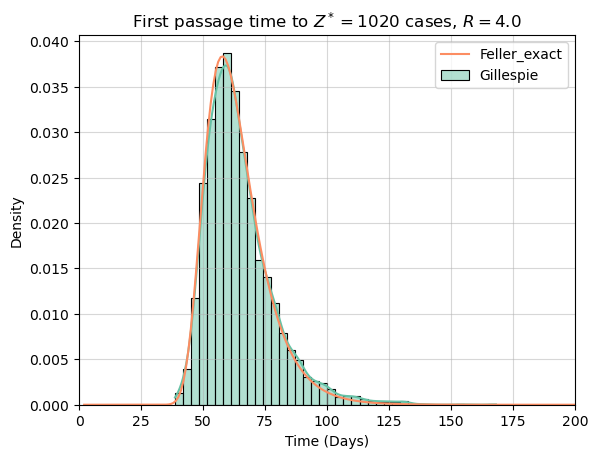

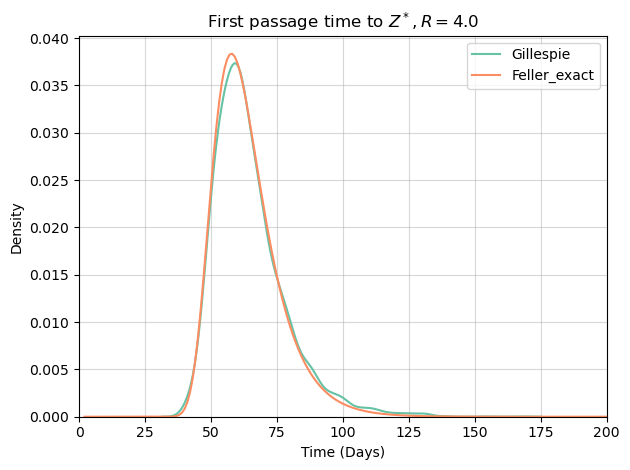

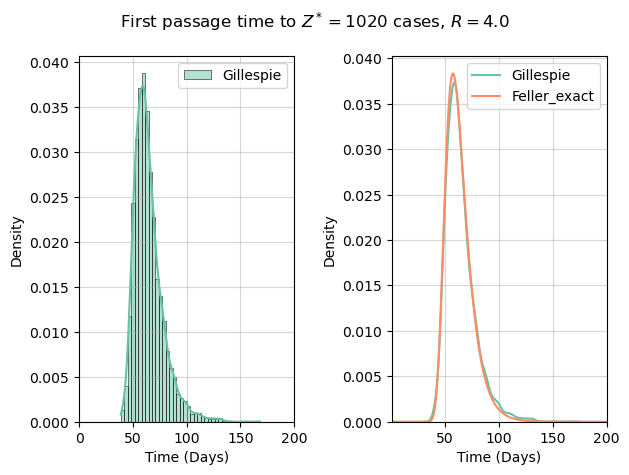

In [183]:
save = 0
R_effective_vec = np.round(Reff_vec, 2)
plt.figure(11)
plt.grid(alpha = 0.5)
sns.histplot(G_test[idx, :], stat = 'density', kde = True, bins = 40, label = 'Gillespie', 
             alpha =0.5)  
plt.plot(time, pdf_chisq, label = "Feller_exact", color = cmp(1))
plt.xlim([0, 200])
plt.xlabel("Time (Days)")
plt.title("First passage time to " + r'$Z^* = $' + str(int(Istars_min[idx])) + " cases, " + r"$R = $" + str(Reff_vec[idx]))
plt.legend()
if save:
    plt.savefig("FPT_gillespie_im=" + str(im) + "_R=" + str(Reff) + "Z=" + str(int(Istars_min[idx]))  + ".pdf")

plt.figure(27)
plt.grid(alpha = 0.5)
# sns.kdeplot(stop_times_df[cols[idx]],  label = 'Feller')
sns.kdeplot(G_test[idx, :], label = 'Gillespie') 
plt.plot(time, pdf_chisq, label = "Feller_exact")
plt.title("First passage time to " + r'$Z^* ,$' + r"$R = $" + str(Reff_vec[idx]))
plt.xlim([0, 200])
plt.xlabel("Time (Days)")
plt.legend()
plt.tight_layout()
#if save:
plt.savefig("FPT_both_im=" + str(im) + "_R=" + str(Reff) + "Z=" + str(int(Istars_min[idx]))  + ".png")

fig, axs = plt.subplots(1, 2)
axs[0].grid(alpha = 0.5)
sns.histplot(G_test[idx, :], stat = 'density', kde = True, bins = 40, label = 'Gillespie', 
             ax = axs[0])
axs[0].set_xlim([0, 200])
axs[0].set_xlabel("Time (Days)")
axs[0].legend()

axs[1].grid(alpha = 0.5)

sns.kdeplot(G_test[idx, :], label = 'Gillespie', ax = axs[1]) 
axs[1].plot(time, pdf_chisq, label = "Feller_exact")
axs[1].set_xlim([1, 200])       
axs[1].set_xlabel("Time (Days)")
axs[1].legend(loc = "upper right")

fig.suptitle("First passage time to " + r'$Z^* = $' + str(int(Istars_min[idx])) + " cases, " + r"$R = $" + str(Reff_vec[idx])) 
fig.tight_layout()
